In [1]:
import torch
import torchvision
from torchvision.transforms import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
print(device)

cuda


In [3]:
image_dir = './'
train_path = './train'
test_path = './test'
print(os.getcwd())
print(os.listdir(image_dir))

/mnt/c/code/ResNet
['.git', 'ResNet50.ipynb', 'result.txt', 'test', 'train']


In [4]:
trainclasses = os.listdir(train_path)
testclasses = os.listdir(test_path)
print(trainclasses, testclasses)

['train_image'] ['test_images_1', 'test_images_2', 'test_images_3', 'test_images_4']


In [5]:
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_path, transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform=resize_trans)

In [6]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.18748468, 0.15022883, 0.11441508], dtype=float32)

In [7]:
def get_mean_std(dataset):
  meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
  stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.mean([s[0] for s in stdRGB])
  stdG = np.mean([s[1] for s in stdRGB])
  stdB = np.mean([s[2] for s in stdRGB])

  print(meanR, meanG, meanB)
  print(stdR, stdG, stdB)
  return [meanR, meanG, meanB], [stdR, stdG, stdB]

In [8]:
resize_mean_train, resize_std_train=get_mean_std(resize_train)
resize_mean_test, resize_std_test=get_mean_std(resize_test)

0.31177345 0.28802562 0.21830535
0.23378305 0.21980956 0.16005285
0.37023798 0.42984772 0.37165824
0.19160993 0.2261645 0.18761593


In [9]:

transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 resize
    transforms.RandomCrop(224), 
    transforms.RandomHorizontalFlip(p = 0.5), # p확률로 이미지 좌우반전
    transforms.ToTensor(),
    #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    transforms.Normalize(resize_mean_train, resize_std_train)
])
"""
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 resize
    transforms.CenterCrop(224), # 이미지를 랜덤으로 크롭
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
"""
transform_test = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224), 
    transforms.ToTensor(),
    #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    transforms.Normalize(resize_mean_test, resize_std_test)
])
trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

In [10]:
trainset[0][0]

tensor([[[ 1.3671,  1.3671,  1.3671,  ..., -0.0084,  0.0083, -0.0084],
         [ 1.3503,  1.3503,  1.3503,  ..., -0.0084, -0.0084, -0.0252],
         [ 1.4006,  1.4006,  1.3839,  ..., -0.2265, -0.2600, -0.2768],
         ...,
         [-0.5117, -0.5284, -0.5284,  ..., -0.9646, -0.9478, -0.9478],
         [-0.5284, -0.5452, -0.5452,  ..., -0.9310, -0.9310, -0.9478],
         [-0.5452, -0.5620, -0.5620,  ..., -0.9478, -0.9478, -0.9646]],

        [[-1.1855, -1.1855, -1.1855,  ...,  2.4184,  2.4362,  2.4362],
         [-1.2033, -1.1855, -1.2033,  ...,  3.0428,  3.0606,  3.0963],
         [-1.2211, -1.2211, -1.2390,  ...,  3.1320,  3.1498,  3.1855],
         ...,
         [-1.0606, -1.0606, -1.0784,  ..., -0.4005, -0.3826, -0.4005],
         [-1.0784, -1.0784, -1.0784,  ..., -0.4183, -0.4361, -0.4361],
         [-1.0606, -1.0606, -1.0784,  ..., -0.4540, -0.4718, -0.4897]],

        [[-1.1679, -1.1679, -1.1679,  ...,  0.3267,  0.3757,  0.4002],
         [-1.1924, -1.1679, -1.1679,  ...,  0

In [11]:
trainloader = DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=0)

In [12]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [13]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0]) # 3 반복
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [14]:
resnet101 = ResNet(resnet.Bottleneck, [3, 4, 23, 3], 3, True).to(device) 
# resnet101
# 1(conv1) + 9(layer1) + 12(layer2) + 69(layer3) + 9(layer4) +1(fc)= ResNet101

In [15]:
from torchsummary import summary
summary(resnet101, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])


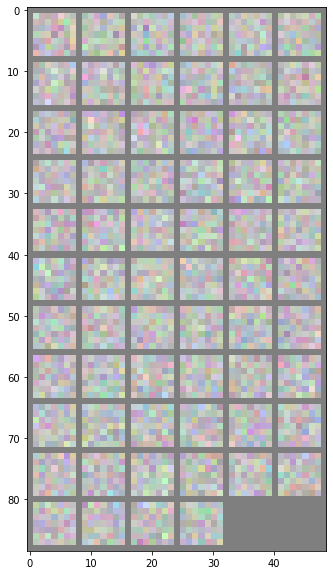

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
for w in resnet101.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

In [17]:
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [18]:
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet101,
    device = device,
    optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.0001),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [19]:
class train():
      def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
        print(len(testloader))
      def train(self, epochs, log_interval):
          self.model.train()
          for epoch in range(1, epochs + 1 ):  # epochs 루프
              running_loss = 0.0
              for i, data in enumerate(self.trainloader, 0): # batch 루프
                  # get the inputs
                  self.globaliter += 1
                  inputs, labels = data # input data, label 분리
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)
                  
                  # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                  self.optimizer.zero_grad() 

                  # forward + backward + optimize
                  outputs = self.model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  self.optimizer.step()
                  running_loss += loss.item()

                  # 30 iteration마다 acc & loss 출력
                  if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0
              lr_sche.step()
                  
      
      print('Finished Training')

Finished Training


In [20]:
ready_to_train=train(config)

3
11


In [21]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=1000, gamma=0.1) # 20 step마다 lr조정
epochs = 300
log_interval = 3

ready_to_train.train(epochs, log_interval)

Train Epoch: 1 [16/40 (40%)]	learningLoss: 0.984160	whole_loss: 0.847876 
Train Epoch: 2 [16/40 (40%)]	learningLoss: 0.613178	whole_loss: 0.514800 
Train Epoch: 3 [16/40 (40%)]	learningLoss: 0.358012	whole_loss: 0.308918 
Train Epoch: 4 [16/40 (40%)]	learningLoss: 0.219626	whole_loss: 0.186948 
Train Epoch: 5 [16/40 (40%)]	learningLoss: 0.135284	whole_loss: 0.121279 
Train Epoch: 6 [16/40 (40%)]	learningLoss: 0.090487	whole_loss: 0.085113 
Train Epoch: 7 [16/40 (40%)]	learningLoss: 0.063030	whole_loss: 0.058610 
Train Epoch: 8 [16/40 (40%)]	learningLoss: 0.043931	whole_loss: 0.037536 
Train Epoch: 9 [16/40 (40%)]	learningLoss: 0.034515	whole_loss: 0.031888 
Train Epoch: 10 [16/40 (40%)]	learningLoss: 0.028788	whole_loss: 0.026720 
Train Epoch: 11 [16/40 (40%)]	learningLoss: 0.023174	whole_loss: 0.024041 
Train Epoch: 12 [16/40 (40%)]	learningLoss: 0.018321	whole_loss: 0.016678 
Train Epoch: 13 [16/40 (40%)]	learningLoss: 0.016574	whole_loss: 0.015482 
Train Epoch: 14 [16/40 (40%)]	lear

In [22]:
def get_representations(model, iterator):
    
    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [23]:
trainoutputs, trainlabels = get_representations(resnet101, trainloader)

In [24]:
from sklearn import decomposition
from sklearn import manifold

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [25]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels,cmap = plt.cm.get_cmap('rainbow', 7))
    handles, _ = scatter.legend_elements(num = None)
    legend = plt.legend(handles = handles, labels = classes)

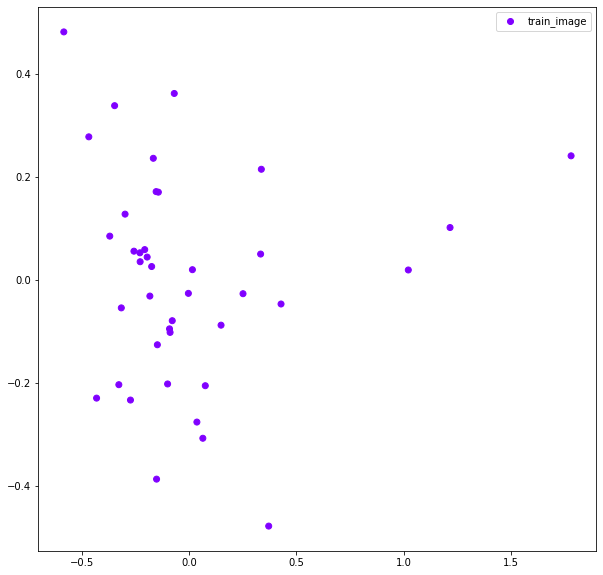

In [26]:
output_pca_data = get_pca(trainoutputs)
plot_representations(output_pca_data, trainlabels, trainclasses)

In [27]:
testoutputs, testlabels = get_representations(resnet101, testloader)

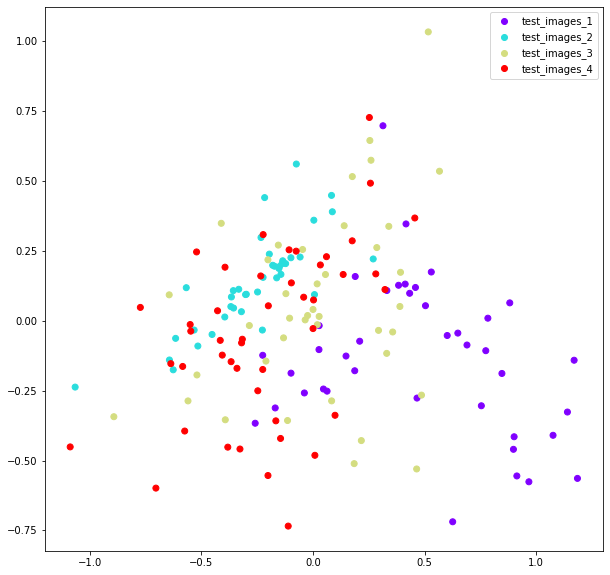

In [28]:
output_pca_data = get_pca(testoutputs)
plot_representations(output_pca_data, testlabels, testclasses)

In [29]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, n_iter=1000)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [30]:
totaloutputs = []
for i in trainoutputs.detach().cpu().numpy():
    totaloutputs.append(i)
for i in testoutputs.detach().cpu().numpy():
    totaloutputs.append(i)
    
totallabels = []
for i in trainlabels.detach().cpu().numpy():
    totallabels.append(i)
for i in testlabels.detach().cpu().numpy():
    totallabels.append(i+1)

totalclasses = trainclasses + testclasses

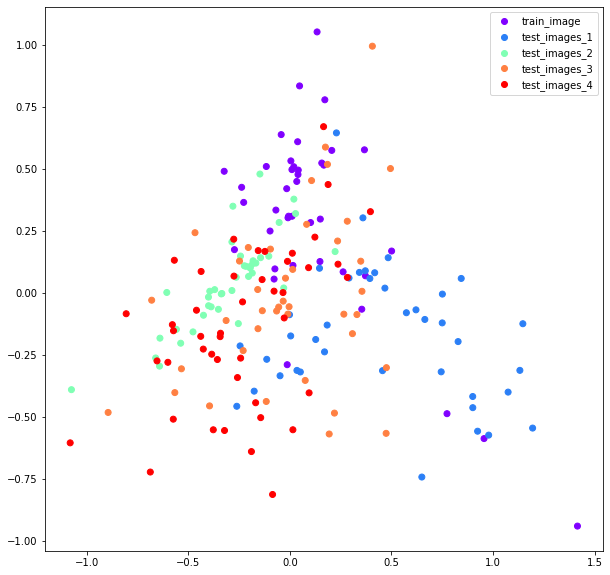

In [31]:
output_pca_data = get_pca(totaloutputs)
plot_representations(output_pca_data, totallabels, trainclasses + testclasses)

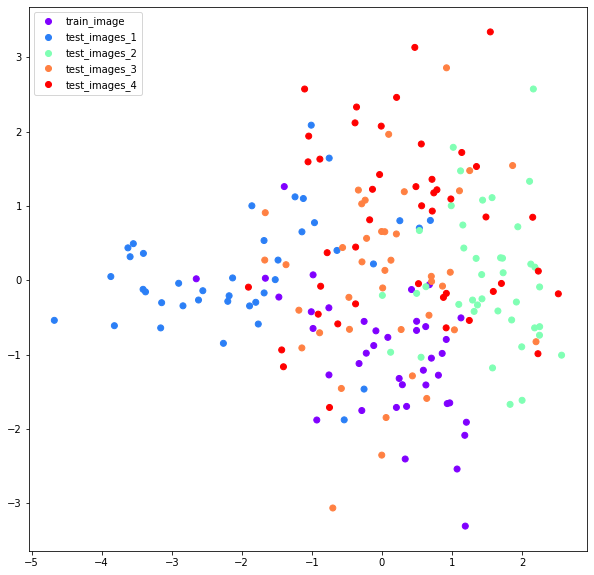

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

output_scaled = StandardScaler().fit_transform(totaloutputs)
lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(output_scaled, totallabels)
output_lda = lda.transform(output_scaled)
plot_representations(output_lda, totallabels, trainclasses + testclasses)

/home/jrin330/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jrin330/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


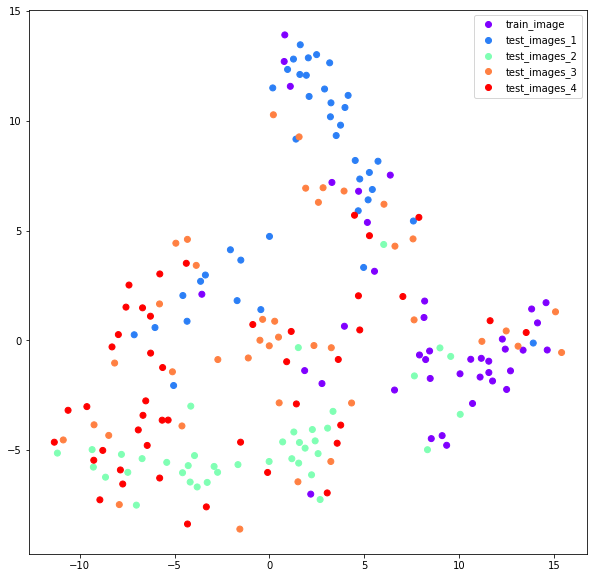

In [33]:
output_tsne_data = get_tsne(totaloutputs)
plot_representations(output_tsne_data, totallabels, trainclasses + testclasses)

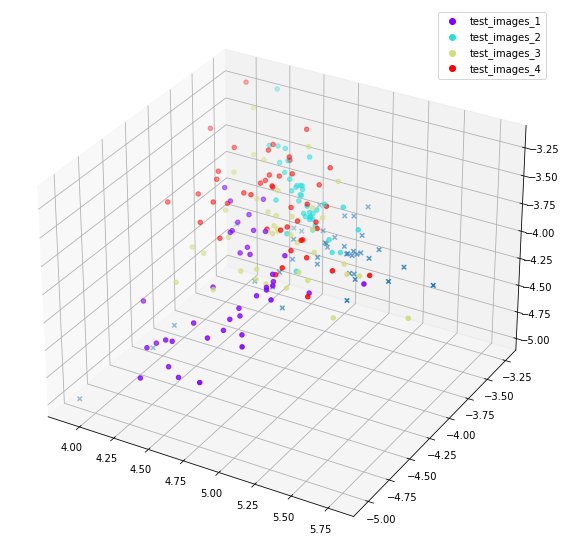

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(trainoutputs[:,0], trainoutputs[:,1], trainoutputs[:,2], marker = 'x')

scatter = ax.scatter(testoutputs[:,0], testoutputs[:,1], testoutputs[:,2], c = testlabels, cmap = plt.cm.get_cmap('rainbow', 7))
handles, _ = scatter.legend_elements(num = None)
legend = plt.legend(handles = handles, labels = testclasses)

#ax.view_init(0,90)
#ax.view_init(90,0)
#ax.view_init(0,0)
#ax.view_init(45,45)
plt.show()

In [35]:
fp = open("result.txt", "w")
fp.write('train output')
fp.write('\n')
for cur in trainoutputs.detach().cpu().numpy():
    fp.writelines(np.array_str(cur))
    fp.write('\n')
fp.write('test output')
fp.write('\n')
for cur in testoutputs.detach().cpu().numpy():
    fp.writelines(np.array_str(cur))
    fp.write('\n')
fp.flush()
fp.close()